In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
from random import gauss
from random import random
from numpy.linalg import inv
!pip install pyunfold
from pyunfold import iterative_unfold
from pyunfold.callbacks import Logger


Your measurement isn't perfect.  You can think about it this way:
$$\vec{M} = \bf{R} \vec{T}$$
You measure something with some precision which is described by a response matrix $\bf{R}$ which operates on the truth, $\vec{T}$.  You are interested in knowing $\bf{T}$.  The process of getting to $\bf{T}$ from $\vec{M}$ is *unfolding*.

Do you know $\bf{R}$?  Yes, you can likely know $\bf{R}$ because it's based on a Monte Carlo simulation of your detector.  The uncertainty on $\bf{R}$ is of course important to know and we'll discuss that below...

The most obvious thing to do is to invert $\bf{R}$ to get:
$$\bf{R^{-1}}\vec{M} = \bf{R^{-1}}\bf{R} \vec{T}$$
$$\bf{R^{-1}}\vec{M} =  \vec{T}$$ Let's try that.

First we'll generate samples, *num_samples*, according to a distribution.  This is what nature made for us.

In [ ]:
sns.set_context(context='poster')
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['lines.markeredgewidth'] = 2

range = 4
nbins = 21
num_samples = int(1e6)
true_samples = np.random.normal(loc=0.0, scale=1.0, size=num_samples)
true_samples
bins = np.linspace(-range, range, nbins)
num_bins = len(bins) - 1
data_true, _ = np.histogram(true_samples, bins=bins)
data_true
fig, ax = plt.subplots()
ax.step(np.arange(num_bins), data_true, where='mid', lw=3,
        alpha=0.7, label='True distribution')
ax.set(xlabel='X bins', ylabel='Counts')
ax.legend()
plt.show()

Now let's mess up the truth.  This is what we think our detector actually measures given these truth samples.  

In [ ]:
noise_width = 0.5
noise_shift = 0.3
random_noise = np.random.normal(loc=noise_shift, scale=noise_width, size=num_samples)
observed_samples = true_samples + random_noise
#observed_samples = true_samples #this was a check I did to make sure that the inversion method worked if I didn't smear the observation
data_observed, _ = np.histogram(observed_samples, bins=bins)
data_observed
fig, ax = plt.subplots()
ax.step(np.arange(num_bins), data_true, where='mid', lw=3,
        alpha=0.7, label='True distribution')
ax.step(np.arange(num_bins), data_observed, where='mid', lw=3,
        alpha=0.7, label='Observed distribution')
ax.set(xlabel='X bins', ylabel='Counts')
ax.legend()
plt.show()

In [56]:
data_observed_err = np.sqrt(data_observed)
data_observed_err

efficiencies = np.ones_like(data_observed, dtype=float)
efficiencies
efficiencies_err = np.full_like(efficiencies, 0.1, dtype=float)
efficiencies_err
response_hist, _, _ = np.histogram2d(observed_samples, true_samples, bins=bins)
response_hist_err = np.sqrt(response_hist)

Here we are going to require each *column* (truth bin) to sum up to the efficiency value (here we've just taken all the efficiencies to be unity so all the columns will add up to one).  This is equivalent to saying that every truth value will be measured somewhere.

In [ ]:
column_sums = response_hist.sum(axis=0)
normalization_factor = efficiencies / column_sums

response = response_hist * normalization_factor
response_err = response_hist_err * normalization_factor
#checking...
response.sum(axis=0)
inv_response_hist = inv(response)
fig, ax = plt.subplots()
im = ax.imshow(response, origin='lower')
cbar = plt.colorbar(im, label='$P(E_i|C_{\mu})$')
ax.set(xlabel='Truth (cause) bins', ylabel='Measured (effect) bins',
       title='Normalized response matrix')
plt.show()


So now we have the response matrix and it's inverse so we can try:
$$\bf{R^{-1}}\vec{M} =  \vec{T}$$

We've called that, awkwardly, "new_truth".

In [ ]:
new_truth = np.matmul(inv_response_hist,data_observed)
#I was surprised that just multiplying the matrices didn't work the way I expcted and I had to find "matmul"...
print(new_truth.shape)
print(inv_response_hist.shape)
print(data_observed.shape)

In [ ]:
fig, ax = plt.subplots()
ax.step(np.arange(num_bins), data_true, where='mid', lw=3,
        alpha=0.7, label='True distribution')
ax.step(np.arange(num_bins), data_observed, where='mid', lw=3,
        alpha=0.7, label='Observed distribution')
ax.step(np.arange(num_bins), new_truth, where='mid', lw=3,
        alpha=0.7, label='from matrix inversion')
ax.set(xlabel='X bins', ylabel='Counts')
ax.legend()
plt.show()
print(new_truth)

Well that didn't work well.  The green curve looks vaguely like the original distribution but it has far too many fluctuations to be useful in any way. Why? Well, let's take a look at this inverse matrix.  What does it look like when we just let the truth equal the observations?  It's easy to go back and turn the noise down to zero.  Seeing that then the inversion works is a trivial but important check.

(Also, run the process of generating the "observed" points that go into the response matrix multiple times; you will see that the inverse of the response matrix changes noticably depending on the particular random number set.)  

Finally, the matrix inversion method requires the response to be a square matrix; from the physics point of view, the response can be square, but need not be.

In [ ]:
fig, ax = plt.subplots()
im = ax.imshow(inv_response_hist, origin='lower')
cbar = plt.colorbar(im, label='')
ax.set(xlabel='Cause bins', ylabel='Effect bins',
       title='Inverse of response matrix')
plt.show()

# Unfolding

So where do we go from here?  The basic idea is *unfolding*.  This improves on the matrix inversion by including some additional infomration.  Usually there is a requirement of a smooth final distribution.  This usually makes sense from a physical point of view but there are some clear dangers here.

There is another approach, convolving any theory you want to compare to with the response function to match the data.  This essentially smears the model to match the data.  The problem with this is that you can't actually compare your measurement to anyone elses directly anymore.  In my world, unfolding is the proper step, but it must be taken with care.

We're going to discuss *Iterative Bayesian Unfolding*.  This is based on Bayes' Theorem (go back to the beginning when we discussed the basics of probability).  This method is documented [here](https://inspirehep.net/literature/374574).

Let's start with:
$$\hat{n}(C_i) = n(E) P(C_i|E) $$
so for each effect $j$:
$$P(C_i|E_j) = \frac{P(E_j|C_i)P_{a}(C_i)}{n(E)}$$
$$P(C_i|E_j) = \frac{P(E_j|C_i)P_{a}(C_i)}{\sum_lP(E_j|C_l)P_a(C_l)}$$

Given a *guess* at what the truth ($P_{a}(C_i)$) and our understanding from simulation of how the pdf for each effect bin in terms of the cause bin, $P(E_j|C_i)$, is we can get a constraint on $P(C_i|E_j)$ and then we have both terms on the rhs of:
$$\hat{n}(C_i) = n(E) P(C_i|E) $$

Then we iterate.  We calcuate $\hat{n}(C_i)$ based on the intial guess and then use, those values as the new $P_a(C_i)$.  We iterate as many times as necessary until $\hat{n}(C_i)$ is stable from one iteration to the next.

In [61]:
unfolded_results = iterative_unfold(data=data_observed,
                                    data_err=data_observed_err,
                                    response=response,
                                    response_err=response_err,
                                    efficiencies=efficiencies,
                                    #ts='rmd',
                                    efficiencies_err=efficiencies_err,
                                    callbacks=[Logger()])

Iteration 1: ts = 0.1997, ts_stopping = 0.01
Iteration 2: ts = 0.0365, ts_stopping = 0.01
Iteration 3: ts = 0.0111, ts_stopping = 0.01
Iteration 4: ts = 0.0040, ts_stopping = 0.01


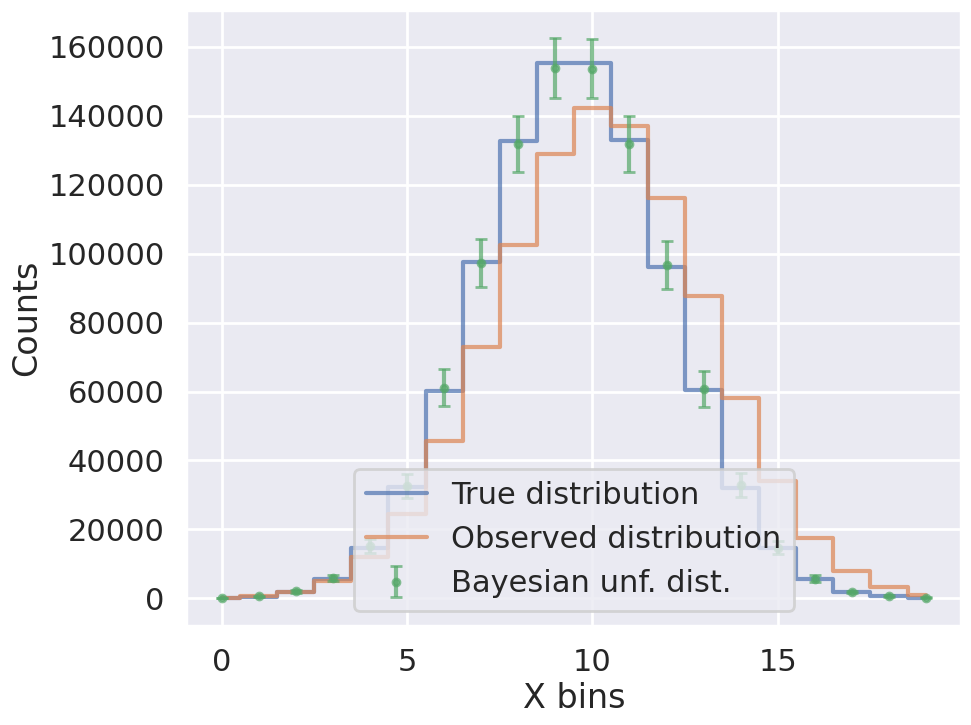

In [62]:
fig, ax = plt.subplots()
ax.step(np.arange(num_bins), data_true, where='mid', lw=3,
        alpha=0.7, label='True distribution')
ax.step(np.arange(num_bins), data_observed, where='mid', lw=3,
        alpha=0.7, label='Observed distribution')
ax.errorbar(np.arange(num_bins), unfolded_results['unfolded'],
            yerr=unfolded_results['sys_err'],
            alpha=0.7,
            elinewidth=3,
            capsize=4,
            ls='None', marker='.', ms=10,
            label='Bayesian unf. dist.')

ax.set(xlabel='X bins', ylabel='Counts')
plt.legend(loc='lower center')
plt.show()



**Additionally, it's worth noting that we have cheated!.** We have generated the response matrix with our truth and our observations, paired together point by point.  In reality everything we've done so far would be with *simulation* and nothing is from our actual measurement. This is great for checking the code (if this doesn't work, we've got errors...).

So now we will generate a new set of observed samples *observed_samples2*.  These are drawn from the same truth function and the same noise parameterizations but are independent of the truth/observed pairs that are used in generating the response matrix.


In [ ]:

#here the ...2 variables are independent of true_samples and observed_samples that we used to make the response
true_samples2 = np.random.normal(loc=0.0, scale=1.0, size=num_samples)
random_noise2 = np.random.normal(loc=noise_shift, scale=noise_width, size=num_samples)
observed_samples2 = true_samples2 + random_noise2
data_observed2, _ = np.histogram(observed_samples2, bins=bins)
data_observed_err2 = np.sqrt(data_observed2)
#now we'll redo the unfolding using as our "measurement"
unfolded_results2 = iterative_unfold(data=data_observed2,
                                    data_err=data_observed_err2,
                                    response=response,
                                    response_err=response_err,
                                    efficiencies=efficiencies,
                                    efficiencies_err=efficiencies_err,
                                    callbacks=[Logger()],
                                     ts_stopping=0.01)

In [ ]:
fig, ax = plt.subplots()
ax.step(np.arange(num_bins), data_true, where='mid', lw=3,
        alpha=0.7, label='True distribution')
ax.step(np.arange(num_bins), data_observed2, where='mid', lw=3,
        alpha=0.7, label='Observed distribution')
ax.errorbar(np.arange(num_bins), unfolded_results2['unfolded'],
            yerr=unfolded_results2['sys_err'],
            alpha=0.7,
            elinewidth=3,
            capsize=4,
            ls='None', marker='.', ms=10,
            label='Bayesian unfolded distribution (independent)')

ax.set(xlabel='X bins', ylabel='Counts')
plt.legend(loc='lower center')
plt.show()



The concept of "closure" is a quantification of how well the unfolding process works.  There are two kinds of closure here:
*  *technical closure* is a measure how how well the smeared 'data' unfolds to the truth it was created from.  
*  *closure* is using independent 'data' from the response matrix generation.

In both cases, the ratio of the unfolded simulation to the truth is used.  Here neither of the closures are very good on the tails of the distributions.  This is most likely because we are not sampling enough counts to populate the Gaussians that far out on the tails.  

In [ ]:
closure = data_observed2/data_true
closure_tech = data_observed/data_true
fig, ax = plt.subplots()
ax.step(np.arange(num_bins), closure, where='mid', lw=3,
        alpha=0.7, label='closure')
ax.step(np.arange(num_bins), closure_tech, where='mid', lw=3,
        alpha=0.7, label='tech. closure')

#ax.errorbar(np.arange(num_bins), unfolded_results2['unfolded'],
#            yerr=unfolded_results2['sys_err'],
#            alpha=0.7,
#            elinewidth=3,
#            capsize=4,
#            ls='None', marker='.', ms=10,
#            label='Bayesian unfolded distribution (independent)')

ax.set(xlabel='X bins', ylabel='Counts')
plt.legend(loc='upper center')
plt.show()


*  With unfolding you don't have information on what a given measured events truth value was.  
*  [Singluar Value Decomposition](https://arxiv.org/pdf/hep-ph/9509307.pdf) provides another way of avoiding the issues with the inversion method.
*   The Bayesian method discussed here is well-suited to multiple dimensions (e.g. you want to unfold in x and y and those measurements are not necessarily independent of each other).  The initial guess becomes harder to constrain with multple dimensions. pyunfold uses a flat prior as default but that is not universal and can be changed.
*   There are those that want to use ML for unfolding.  This seems likely to create a dangerous dependence on the model without very careful checks (especially combined with multi-dimensional unfolding). A recent paper is [here](https://inspirehep.net/literature/1766424).  The code is [here](https://github.com/ericmetodiev/OmniFold).
*   The best way to reduce all of these issues/worries is to have an unfolding with the most diagonal response matrix possible, then the unfolding process has to do less work.
*   Pyunfold propagates the uncertainties directly.  Often the error propagation is done using bootstrapping for simplicity.